$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

In [1]:
from __future__ import division
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;

# scientific
import numpy as np;

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'transition': 'none',
              'start_slideshow_at': 'beginning',
});

# EECS 545:  Machine Learning
## Lecture 04:  Linear Regression I
* Instructor:  **Jacob Abernethy**
* Date:  January 20, 2015


*Lecture Exposition Credit: Benjamin Bray*

# Outline for this Lecture
- Introduction to Regression
- Solving Least Squares
    - Gradient Descent Method
    - Closed Form Solution
    
# Reading List
- Required:    
    - **[PRML]**, §1.1: Polynomial Curve Fitting Example
    - **[PRML]**, §3.1: Linear Basis Function Models
- Optional:
    - **[MLAPP]**, Chapter 7: Linear Regression

> In this lecture, we will cover linear regression. First some basic concepts and examples of linear regression will be introduced. Then we will show solving linear regression can be done by solving least squares problem. To solve least squares problem, two methods will be given: *gradient descent method* and *closed form solution*. Finally, the concept of Moore-Penrose pseudoinverse is introduced which is highly related to least squares.

# Supervised Learning

- Goal
    - Given data $X$ in feature sapce and the labels $Y$
    - Learn to predict $Y$ from $X$
- Labels could be discrete or continuous
    - Discrete-valued labels:  Classification
    - Continuous-valued labels:  Regression
    
<img src="images/classification-regression.png">

# Notation

- In this lecture, we will use
    - Let vector $\vec{x}_n \in \R^D$ denote the $i\text{th}$ data. $D$ denotes number of attributes in dataset.
    - Let vector $\phi(\vec{x}_n) \in \R^M$ denote features for data $\vec{x}_n$. $\phi_j(\vec{x}_n)$ denotes the $j\text{th}$ feature for data $x_n$.
    - Feature $\phi(\vec{x}_n)$ is the *artificial* features which represents the preprocessing step. $\phi(\vec{x}_n)$ is usually some combination of transformations of $\vec{x}_n$. For example, $\phi(\vec{x})$ could be vector constructed by $[\vec{x}_n^T, \cos(\vec{x}_n)^T, \exp(\vec{x}_n)^T]^T$. If we do nothing to $\vec{x}_n$, then $\phi(\vec{x}_n)=\vec{x}_n$.
    - Continuous-valued label vector $t \in \R^D$ (target values). $t_n \in \R$ denotes the target value for $i\text{th}$ data.

## Notation: Example
- The table below is a dataset describing acceleration of the aircraft along a runway. Based on our notations above, we have $D=7$. Regardless of the header row, target value $t$ is the first column and $x_n$ denote the data on the $n\text{th}$ row, $2\text{th}$ to $7\text{th}$ columns.
- We could manipulate the data to have our own features. For example,
    - If we only choose the first three attributes as features, i.e. $\phi(\vec{x}_n)=\vec{x}_n[1:3]$, then $M=3$
    - If we let $\phi(\vec{x}_n)=[\vec{x}_n^T, \cos(\vec{x}_n)^T, \exp(\vec{x}_n)^T]$, then  $M=3 \times D=21$
    - We could also let $\phi(\vec{x}_n)=\vec{x}_n$, then $M=D=7$. This will occur frequently in later lectures.
<center> <img src="http://www.flightdatacommunity.com/wp-content/uploads/2014/08/3rd-blog-on-linear-regression-table-1.png"  style="width:600px;height:200px;"> </center>
<div align="right"><span style="color:gray; font-size:10px">(Example taken from [here](http://www.flightdatacommunity.com/linear-regression-applied-to-take-off/))</span></div>

# Linear Regression 

## Linear Regression (1D Inputs)

- Consider 1D case (i.e. D=1)
    - Given a set of observations $x_1, \dots, x_N \in \R^M$
    - and corresponding target values $t_1, \dots, t_N$
- We want to learn a function $y(x_n, \vec{w}) \approx t_n$ to predict future values.
$$
y(x_n, \vec{w})
= w_0 + w_1 x_n + w_2 x_n^2 + \dots w_{M-1} x_n^{M-1}
= \sum_{k=0}^{M-1} w_k x_n^k
= \vec{w}^T\phi(x_n)
$$
of which feature coefficient $\vec{w}=[w_0, w_1, w_2, \dots ,w_{M-1}]^T$, feature $\phi(x_n)=[1, x_n, x_n^2, \dots, x_n^{M-1}]$ (here we add a bias term $\phi_0(x_n)=1$ to features).

## Regression: Noisy Data

In [3]:
def regression_example_draw(degree1, degree2, degree3, ifprint):
    x = np.linspace(0, 2*np.pi, 13);
    # np.random.randn generates gaussian samples
    y = np.sin(x) + np.random.randn(x.shape[0]) * 0.2; 
    xx = np.linspace(0, 2*np.pi, 100);
    plt.figure(figsize=(12,7.5))
    plt.subplot(221)
    plt.plot(xx, np.sin(xx), '-g', x,y, 'or')
    plt.legend(['True Curve','Data']); plt.title('Data and True Curve');

    # Here were are going to take advantage of numpy's 'polyfit' function
    # This implements a "polynomial fitting" algorithm
    # coeffs are the optimal coefficients of the polynomial
    coeffs = np.polyfit(x, y, degree1); # 0 is the degree of the poly
    # We construct poly(), the polynomial with "learned" coefficients
    poly = np.poly1d(coeffs);
    plt.subplot(222)
    plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");
    plt.legend(['True Curve','Data','Learned Curve']); plt.title(str(degree1)+'th Order Polynomial')
    exprsn1=''
    for i in range(degree1+1):
        if i>0 and coeffs[i]>0:
            exprsn1 += '+%.3fx^%d' %(coeffs[i], i)
        elif i==0:
            exprsn1 += '%.3f' %(coeffs[i])
        else:
            exprsn1 += '%.3fx^%d' %(coeffs[i], i)            

    coeffs = np.polyfit(x, y, degree2); # Now let's try degree = 1
    poly = np.poly1d(coeffs);
    plt.subplot(223)
    plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");
    plt.legend(['True Curve','Data','Learned Curve']); plt.title(str(degree2)+'th Order Polynomial')
    exprsn2 = ''
    for i in range(degree2+1):
        if i>0 and coeffs[i]>0:
            exprsn2 += '+%.3fx^%d' %(coeffs[i], i)
        elif i==0:
            exprsn2 += '%.3f' %(coeffs[i])
        else:
            exprsn2 += '%.3fx^%d' %(coeffs[i], i)

    coeffs = np.polyfit(x, y, degree3); # Now degree = 3
    poly = np.poly1d(coeffs);
    plt.subplot(224)
    plt.plot(xx, np.sin(xx), "-g", x, y, "or", xx, poly(xx), "-b");
    plt.legend(['True Curve','Data','Learned Curve']); plt.title(str(degree3)+'th Order Polynomial')
    plt.show()
    exprsn3 = ''
    for i in range(degree3+1):
        if i>0 and coeffs[i]>0:
            exprsn3 += '+%.3fx^%d' %(coeffs[i], i)
        elif i==0:
            exprsn3 += '%.3f' %(coeffs[i])
        else:
            exprsn3 += '%.3fx^%d' %(coeffs[i], i)
    
    if ifprint:
        print 'The expression for the first polynomial is y=' + exprsn1
        print 'The expression for the second polynomial is y=' + exprsn2
        print 'The expression for the third polynomial is y=' + exprsn3

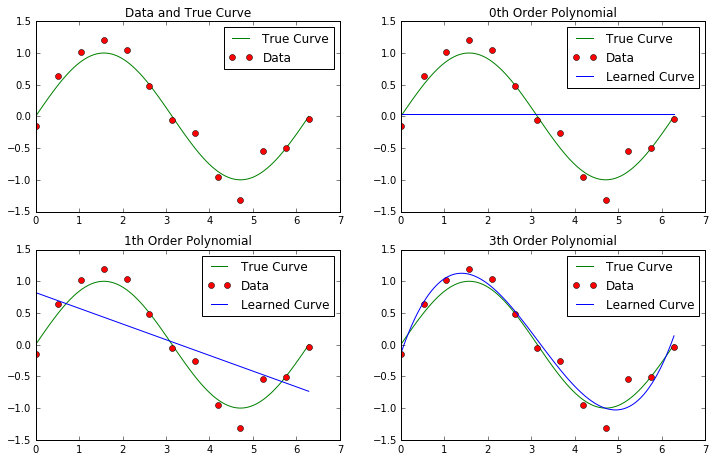

The expression for the first polynomial is y=0.043
The expression for the second polynomial is y=-0.248+0.822x^1
The expression for the third polynomial is y=0.097-0.922x^1+2.007x^2-0.143x^3


In [4]:
regression_example_draw(degree1=0,degree2=1,degree3=3, ifprint=True)

> **Remark**
>    - In the above image, we try to predict the true sinusoidal curve hidden in the data.
>    - $0\text{th}$ order means $\phi(x_n)=1$
>    - $1\text{th}$ order means $\phi(x_n)=[1, x_n]^T$
>    - $3\text{th}$ order means $\phi(x_n)=[1, x_n, x_n^2, x_n^3]^T$
>    - As the degree M increases, the learned curve matches the observed data better

## Basis Functions
- For feature basis function, we used polynomial functions for example above. 
- In fact, we have multiple choices for basis function $\phi_j(\vec{x})$.
- Different basis functions will produce different features, thus may have different performances in prediction.

In [5]:
def set_nice_plot_labels(axs):
    axs[0].set_title(r"$ \phi_j(x) = x^j$", fontsize=18, y=1.08);
    axs[0].set_xlabel("Polynomial", fontsize=18);
    axs[1].set_title(r"$ \phi_j(x) = \exp\left( - \frac{(x-\mu_j)^2}{2s^2} \right)$", fontsize=18, y=1.08);
    axs[1].set_xlabel("Gaussian", fontsize=18);
    axs[2].set_title(r"$ \phi_j(x) = (1  + \exp\left(\frac{\mu_j-x}{s}\right))^{-1}$", fontsize=18, y=1.08);
    axs[2].set_xlabel("Sigmoid", fontsize=18);
    
def basis_function_plot():    
    x = np.linspace(-1,1,100);
    f, axs = plt.subplots(1, 3, sharex=True, figsize=(12,4));
    for j in range(8):
        axs[0].plot(x, np.power(x,j));
        axs[1].plot(x, np.exp( - (x - j/7 + 0.5)**2 / 2*5**2 ));
        axs[2].plot(x, 1 / (1 + np.exp( - (x - j/5 + 0.5) * 5)) );

    set_nice_plot_labels(axs) # I'm hiding some helper code that adds labels

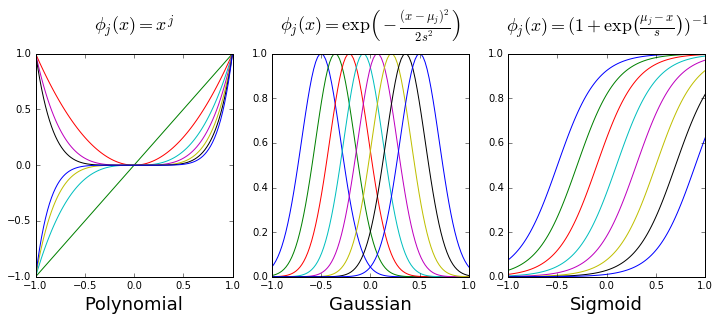

In [6]:
basis_function_plot()

## Linear Regression (General Case)
- The function $y(\vec{x}_n, \vec{w})$ is linear in parameters $\vec{w}$.
    - **Goal:** Find the best value for the weights $\vec{w}$.
    - For simplicity, add a **bias term** $\phi_0(\vec{x}_n) = 1$.
$$
\begin{align}
y(\vec{x}_n, \vec{w})
&= w_0 \phi_0(\vec{x}_n)+w_1 \phi_1(\vec{x}_n)+ w_2 \phi_2(\vec{x}_n)+\dots +w_{M-1} \phi_{M-1}(\vec{x}_n) \\
&= \sum_{j=0}^{M-1} w_j \phi_j(\vec{x}_n) \\
&= \vec{w}^T \phi(\vec{x}_n)
\end{align}
$$
of which $\phi(\vec{x}_n) = [\phi_0(\vec{x}_n),\phi_1(\vec{x}_n),\phi_2(\vec{x}_n), \dots, \phi_{M-1}(\vec{x}_n)]^T$


# Least Squares
## Least Squares: Objective Function
- We will find the solution $\vec{w}$ to linear regression by minimizing a cost/objective function.
- When the objective function is sum of squared errors (sum differences between target $t$ and prediction $y$ over entire training data), this approach is also called **least squares**.
- The objective function is 
$$
E(\vec{w}) 
= \frac12 \sum_{n=1}^N (y(\vec{x}_n, \vec{w}) - t_n)^2
= \frac12 \sum_{n=1}^N \left( \sum_{j=0}^{M-1} w_j\phi_j(\vec{x}_n) - t_n \right)^2
= \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2
$$
<center> <img src="images/least-squares-objective.png"  style="width:304px;height:228px;"> </center>
<center><span>(Minizing the objective function is equivalent to minimizing sum of squares of green segments.)</span></center>

## How to Minimize the Objective Function?
- We will solve the least square problem in two approaches:
    - **Gradient Descent** Method: approach the solution step by step. We will show two ways when iterate:
        - **Batch Gradient Descent**
        - **Stochastic Gradient Descent**
    - **Closed Form** Solution

### Method I: Gradient Descent—Gradient Calculation
- To minimize the objective function, take derivative w.r.t coefficient vector $\vec{w}$:
$$
\begin{align}
\nabla_\vec{w} E(\vec{w})
&= \frac{\partial}{\partial \vec{w}} \left[ \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 \right] \\
&= \sum_{n=1}^N \frac{\partial}{\partial \vec{w}} \left[ \frac12 \left( \vec{w}^T\phi(x_n) - t_n \right)^2 \right] \\
\text{Applying chain rule:}
&= \sum_{n=1}^N \left[ \frac12 \cdot 2 \cdot  \left( \vec{w}^T\phi(x_n) - t_n \right) \cdot \frac{\partial}{\partial \vec{w}} \vec{w}^T\phi(x_n) \right] \\
&= \sum_{n=1}^N \left( \vec{w}^T\phi(x_n) - t_n \right)\phi(x_n)
\end{align}
$$
- Since we are taking derivative of a scalar $E(\vec{w})$ w.r.t a vector $\vec{w}$, the derivative $\nabla_\vec{w} E(\vec{w})$ will be a vector.
- For details about matrix/vector derivative, please refer to appendix attached in the end of the slide.

### Method I-1: Gradient Descent—Batch Gradient Descent
- **Input**: Given dataset $\{(\vec{x}_n, t_n)\}_{n=1}^N$
- **Initialize**: $\vec{w}_0$, learning rate $\eta$
- **Repeat** until convergence:
    - $\nabla_{\vec{w}_{old}} E(\vec{w}) = \sum_{n=1}^N \left( \vec{w}_{old}^T\phi(\vec{x}_n) - t_n \right)\phi(\vec{x}_n)$
    - $\vec{w}_{new} = \vec{w}_{old}-\eta \nabla_{\vec{w}_{old}} E(\vec{w})$
- **End**
- **Output**: $\vec{w}_{final}$

### Method I-2: Gradient Descent—Stochastic Gradient Descent
**Main Idea:**  Instead of computing batch gradient (over entire training data), just compute gradient for individual training sample and update.

- **Input**: Given dataset $\{(\vec{x}_n, t_n)\}_{n=1}^N$
- **Initialize**: $\vec{w}_0$, learning rate $\eta$
- **Repeat** until convergence:
    - Random shuffle $\{(\vec{x}_n, t_n)\}_{n=1}^N$
    - **For** $n=1,\dots,N$ **do**:
        - $\nabla_{\vec{w}_{old}}E(\vec{w} | \vec{x}_n) = \left( \vec{w}_{old}^T\phi(\vec{x}_n) - t_n \right)\phi(\vec{x}_n)$
        - $\vec{w}_{new} = \vec{w}_{old}-\eta \nabla_{\vec{w}_{old}}E(\vec{w} | \vec{x}_n)$
    - **End**
- **End**
- **Output**: $\vec{w}_{final}$

> **Remark   **
>    - The derivative is computed as followimg:
    $$
    \begin{align}
    \nabla_\vec{w}E(\vec{w} | \vec{x}_n)
    &= \frac{\partial}{\partial \vec{w}} \left[ \frac12 \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 \right] \\
    &= \left( \vec{w}^T\phi(\vec{x}_n) - t_n \right)\phi(\vec{x}_n)
    \end{align}
    $$

>    - This derivative w.r.t individual sample is just one summand of gradient in batch gradient descent.
>    - Sometimes, stochastic gradient descent has faster convergence than batch gradient descent.

### Method II: Closed Form Solution
**Main Idea:** Compute gradient and set to gradient to zero, solving in closed form.
- Objective Function $E(\vec{w}) = \frac12 \sum_{n=1}^N \left( \vec{w}^T \phi(\vec{x}_n) - t_n \right)^2 = \frac12 \sum_{n=1}^N \left( \phi(\vec{x}_n)^T \vec{w} - t_n \right)^2$
- Let $\vec{e} = [\phi(\vec{x}_1)^T \vec{w} - t_1,\quad \phi(\vec{x}_2)^T \vec{w} - t_2, \quad \dots ,\quad \phi(\vec{x}_N)^T \vec{w} - t_N]^T$, we have $$E(\vec{w}) = \frac12 \vec{e}^T \vec{e} = \frac12 \parallel \vec{e}\ \parallel^2$$
- Look at $\vec{e}$:
$$
\vec{e} = 
\begin{bmatrix}
\phi(\vec{x}_1)^T\\ 
\vdots\\
\phi(\vec{x}_N)^T
\end{bmatrix}
\vec{w}-
\begin{bmatrix}
t_1\\ 
\vdots\\
t_N
\end{bmatrix}
\triangleq \Phi \vec{w}-\vec{t}
$$
Here $\Phi \in \R^{N \times M}$ is called **design matrix**. Each row represents one sample. Each column represents one feature
$$\Phi = \begin{bmatrix}
\phi(\vec{x}_1)^T\\ 
\phi(\vec{x}_2)^T\\ 
\vdots\\
\phi(\vec{x}_N)^T
\end{bmatrix}
= \begin{bmatrix}
\phi_0(\vec{x}_1) & \phi_1(\vec{x}_1) & \cdots & \phi_{M-1}(\vec{x}_1) \\
\phi_0(\vec{x}_2) & \phi_1(\vec{x}_2) & \cdots & \phi_{M-1}(\vec{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\vec{x}_N) & \phi_1(\vec{x}_N) & \cdots & \phi_{M-1}(\vec{x}_N) \\
\end{bmatrix}
$$

- From $E(\vec{w}) = \frac12 \parallel \vec{e} \parallel^2 = \frac12 \vec{e}^T \vec{e}$ and $\vec{e}=\Phi \vec{w}-\vec{t}$, we have
$$
\begin{align}
E(\vec{w}) 
& = \frac12 \parallel \Phi \vec{w}-\vec{t} \parallel^2=\frac12 (\Phi \vec{w}-\vec{t})^T (\Phi \vec{w}-\vec{t}) \\
& = \frac12 \vec{w}^T \Phi^T \Phi \vec{w} - \vec{t}^T \Phi \vec{w} + \frac12 \vec{t}^T \vec{t}
\end{align}
$$
- So the derivative is $$\nabla_\vec{w} E(\vec{w}) = \Phi^T\Phi - \Phi^T \vec{t}$$

> **Remark**
>    - Note that this derivative can simply be obtained from the derivative we just derived in gradient descent method, which is
$$
\begin{align}
\nabla_\vec{w} E(\vec{w}) 
&= \sum_{n=1}^N \left( \vec{w}^T\phi(x_n) - t_n \right)\phi(x_n) & \text{non-matrix/vector form}  \\
&= \Phi^T\Phi \vec{w} - \Phi^T \vec{t} & \text{matrix/vector form} 
\end{align}
$$
>    - For gradient descent and closed form solution we obtain the derivative from two different perspectives, **non-matrix/vector** form and **matrix/vector** form. You could choose whichever you like when in use. We suggest matrix/vector form which is more neat.
>    - From $\vec{e}=\Phi \vec{w}-\vec{t}$, we know that $\Phi \vec{w}$ is the prediction of training samples and $\vec{e}$ is just the residual error. What we are doing in least squares is just making prediction of training samples as close to training labels as possible, i.e. $\Phi \vec{w} \approx \vec{t}$

- To minimize $E(\vec{w})$, we need to let $\nabla_\vec{w} E(\vec{w}) = \Phi^T\Phi \vec{w} - \Phi^T \vec{t} = 0$, which is also $\Phi^T\Phi \vec{w} = \Phi^T \vec{t}$
- When $\Phi^T \Phi$ is **invertible** ($\Phi$ has *linearly independent columns*), we simply have 
$$
\begin{align}
\hat{\vec{w}}
&=(\Phi^T \Phi)^{-1} \Phi^T \vec{t} \\
&\triangleq \Phi^\dagger \vec{t}
\end{align}
$$
of which $\Phi^\dagger$ is called the **Moore-Penrose Pseudoinverse** of $\Phi$.
- We will talk about case $\Phi^T \Phi$ is **non-invertible** later.

> **Remark**
>    - A common mistake is writing $\hat{\vec{w}}=(\Phi^T \Phi)^{-1} \Phi^T \vec{t}=\Phi^{-1}(\Phi^T)^{-1}\Phi^T \vec{t}=\Phi^{-1} \vec{t}$. This is wrong because $\Phi$ is not necessarily square and invertible.
>    - When $\Phi$ is square and invertible, you are free to write that.

### Digression: Moore-Penrose Pseudoinverse
- When we have a matrix $A$ that is non-invertible or *not even square*, we might want to invert anyway
- For these situations we use $A^\dagger$, the **Moore-Penrose Pseudoinverse** of $A$
- In general, we can get $A^\dagger$ by SVD: if we write $A \in \R^{m \times n} = U_{m \times m} \Sigma_{m \times n} V_{n \times n}^T$ then $A^\dagger \in \R^{n \times m} = V \Sigma^\dagger U^T$, where $\Sigma^\dagger \in \R^{n \times m}$ is obtained by taking reciprocals of *non-zero entries* of $\Sigma^T$.
- Particularly, when $A$ has linearly independent columns then $A^\dagger = (A^T A)^{-1} A^T$. When $A$ is invertible, then $A^\dagger = A^{-1}$.

> **Remark**
>- The solution to $A\vec{x}=\vec{b}$ is $\hat{\vec{x}}=A^{\dagger}b$ in the sense that $\parallel A\vec{x} - \vec{b} \parallel_2^2$ is minimized. Meanwhile, among all the minimizers that achieve the same minimal value of $\parallel A\vec{x} - \vec{b} \parallel_2^2$, $\hat{\vec{x}}$ has the smallest norm $\parallel \vec{x} \parallel_2$.
>- $Ax$ **doesn't necessarily** equal $\vec{b}$:
>    - When $\vec{b}$ is in the column space of $A$, $A\vec{x} = \vec{b}$.
>    - When $\vec{b}$ is **not** in the column space of $A$, $A\vec{x} \neq \vec{b}$.        

### Back to Closed Form Solution
- From previous derivation, we have $\hat{w}=(\Phi^T \Phi)^{-1} \Phi^T \vec{t} \triangleq \Phi^\dagger \vec{t}$.
- What if $\Phi^T \Phi$ is non-invertible? This corresponds to the case where $\Phi$ doesn't have linearly independent columns. For dataset, this means the feature vector of certain sample is the linear combination of feature vectors of some other samples.
- We could still resolve this using pseudoinverse.
- To make $\nabla_\vec{w} E(\vec{w}) = \Phi^T\Phi \vec{w} - \Phi^T \vec{t} = 0$, we have
$$ \hat{\vec{w}} = (\Phi^T\Phi)^\dagger \Phi^T \vec{t} = \Phi^\dagger \vec{t}$$
of which $(\Phi^T\Phi)^\dagger\Phi^T = \Phi^\dagger$. This is left as an exercise. (**Hint:** use SVD)
- Now we could conclude the optimal $\vec{w}$ in the sense that minimizes sum of squared errors is $$\hat{\vec{w}} = \Phi^\dagger \vec{t}$$

>**Remark**
> - In the above derivation, we get $\hat{\vec{w}} = \Phi^\dagger \vec{t}$ by letting the derivative $\nabla_\vec{w} E(\vec{w})=0$. Actually, $\hat{\vec{w}}=\Phi^\dagger \vec{t}$ is just the solution to $\Phi \vec{w} = \vec{t}$ in the sense that $\parallel \Phi\vec{w} - \vec{t} \parallel_2^2$ is minimized. Meanwhile, among all the minimizers that achieve the same minimal value of $\parallel \Phi\vec{w} - \vec{t} \parallel_2^2$, $\hat{\vec{w}}$ has the smallest norm $\parallel \vec{w} \parallel_2$.
> - Now that we have neat and closed form solution to least squares, why do we introduce gradient descent method?
>     - $\hat{w}=(\Phi^T \Phi)^{-1} \Phi^T \vec{t}$ involves matrix inversion. It could be quite computationally expensive when the dimension $M$ is high. On the other hand, gradient descent involves nothing but matrix multiplication which can be computed much faster.

# Appendix I: Differential Operation in Matrix Calculus
## General Gradient
- Suppose that $f : \R^{m \times n} \rightarrow \R$, that is, the function $f$
    - takes as input a matrix $A \in \R^{m\times n} = [a_{ij}]$
    - returns a real value

- Then, the **gradient** of $f$ with respect to $A$ is:

$$
\nabla_A f(A) \in \R^{m \times n} = \begin{bmatrix}
%
\frac{\partial f}{\partial a_{11}}
    & \frac{\partial f}{\partial a_{12}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{1n}} \\ 
%
\frac{\partial f}{\partial a_{21}}
    & \frac{\partial f}{\partial a_{22}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{2n}} \\
%
\vdots & \vdots & \ddots & \vdots \\
%
\frac{\partial f}{\partial a_{m1}}
    & \frac{\partial f}{\partial a_{m2}} 
    & \cdots 
    & \frac{\partial f}{\partial a_{mn}} \\ 
\end{bmatrix}
$$

$$
[\nabla_A f(A)]_{ij} = \frac{\partial f}{\partial a_{ij}}
$$

- Note that the size of $\nabla_A f(A)$ is always the same as the size of $A$.  
- In particular, if $A$ is a vector $\vec{x} \in \R^n$,
$$
\nabla_\vec{x} f(\vec{x}) = \begin{bmatrix}
    \frac{\partial f}{\partial \vec{x}_1} \\
    \frac{\partial f}{\partial \vec{x}_2} \\
    \cdots \\
    \frac{\partial f}{\partial \vec{x}_n}
\end{bmatrix}
$$

- The gradient is a **linear operator** from $\R^n \mapsto \R^n$:
    - $ \nabla_x (f + g) = \nabla_x f + \nabla_x g $
    - $ \forall\, c \in \R, \nabla_x (c f) = c \nabla_x f$

## Gradient of Linear Functions
- The gradient of the **linear function** $f(\vec{x}) = \sum_{k=1}^n b_k x_k = \vec{b}^T \vec{x}$ is
$$
\frac{\partial f}{\partial x_k}
= \frac{\partial}{\partial x_k} \sum_{k=1}^n b_k x_k
= \sum_{k=1}^n \frac{\partial}{\partial x_k} b_k x_k
= b_k
$$
- Compact form
$$
\nabla_\vec{x} \vec{b}^T \vec{x} = \vec{b}
$$
- Similarly,
$$
\nabla_\vec{x} \vec{x}^T \vec{b} = \vec{b}
$$

## Gradient of Quadratic Forms
- Every symmetric $A \in \R^{n \times n}$ corresponds to a **quadratic form**:
    $$ f(x) = \sum_{i=1}^n \sum_{j=1}^n x_i A_{ij} x_j = \vec{x}^T A \vec{x} $$
- The partial derivatives are
    $$ 
    \frac{\partial f}{\partial x_k}
    = 2 \sum_{j=1}^n A_{ij} x_j
    = 2 [A\vec{x}]_i
    $$
- Compact form $$\nabla_\vec{x} \vec{x}^T A \vec{x} = 2 A \vec{x}$$

# Appendix II:  Geometric Interpretation of Least Squares
- Assume number of samples is much larger than number of features, i.e. $N>>M$ ($\Phi \in \R^{N \times M}$ is a *tall* matrix).
- The columns of $\Phi$ construct a $M$-dimensional subspace $\mathcal{S}$.
- Target $\mathbf t = (t_1, \dots, t_N)$ is a vector in $N$-dimensional space
- Prediction $\vec{y}(\mathcal{D}, \vec{w}) = \Phi \vec{w} \in \mathcal{S}$.
- The prediction $\hat{\vec{y}} (\mathcal{D}, \hat{\vec{w}})$ we get via least squares is the projection of $\vec{t}$ onto $\mathcal{S}$. In other words, of all $\vec{w} \in \R^{M}$, $\hat{\vec{w}}$ has smallest $\parallel \Phi \vec{w} \parallel$.    
<center> <img src="images/least-squares-projection.png"  style="width:404px;height:228px;"> </center>